# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

# Inhalt..

In [1762]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from time import time
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

# 1. Data Exploration and Cleaning
## 1.1 Portfolio


**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

Moreover, some further information given about the offers is that there are 3 different offer types:
* BOGO - buy one get one free
* Discount - discount with purchase
* Informational - provides information about products

In [1763]:
#Check portfolio shape to see what size we are dealing with
portfolio.shape

(10, 6)

In [1764]:
#Get info, to get better overview
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   reward      10 non-null     int64 
 1   channels    10 non-null     object
 2   difficulty  10 non-null     int64 
 3   duration    10 non-null     int64 
 4   offer_type  10 non-null     object
 5   id          10 non-null     object
dtypes: int64(3), object(3)
memory usage: 608.0+ bytes


In [1765]:
#get a subest of the data to understand better
portfolio.head(11)

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


In [1766]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [1767]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

The Portfolio dataset doesnt hold that much information. Only ten entries, and the data is already quit tidy. The quantitative data is missing the metric it is meassured with. 
### Portfolio Data Cleaning
There is no missing data, but the channels column ist nested and needs to be broken up in catergorical variables.

In [1768]:
#Convert channels into catergorical data
dummy = pd.get_dummies(portfolio.channels.apply(pd.Series).stack()).sum(level=0)
portfolio = pd.concat([portfolio, dummy], axis=1)
portfolio = portfolio.drop(columns='channels')
#dummy2 = pd.get_dummies(portfolio['offer_type'])
#portfolio = pd.concat([portfolio, dummy2], axis=1)
#portfolio = portfolio.drop(columns='offer_type')
portfolio

,reward,difficulty,duration,offer_type,id,email,mobile,social,web
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,10,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,3,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,7,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


In [1769]:
portfolio['duration'] = portfolio['duration']*24
portfolio = portfolio.rename(columns={'id':'offer_id'})
portfolio

,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,10,10,168,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0
1,10,10,120,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,96,informational,3f207df678b143eea3cee63160fa8bed,1,1,0,1
3,5,5,168,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1
4,5,20,240,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1
5,3,7,168,discount,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1
6,2,10,240,discount,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1
7,0,0,72,informational,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0
8,5,5,120,bogo,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1
9,2,10,168,discount,2906b810c7d4411798c6938adc9daaa5,1,1,0,1


Offer Type is not yet one hote encoded, because is more usful this way to vizualization

## 1.2 Profile
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

The two ID in the different dataset are not the same, so they have to be renamed to not mix them up.

In [1770]:
#get shape to see the size
profile.shape

(17000, 5)

In [1771]:
#get a subset of the data to better understand
profile.head()

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


In [1772]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


In [1773]:
#get the null values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

There are lot of null values. In the data cleaning we have to check how we handle them.

In [1774]:
profile[profile.isnull().any(axis=1)]

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
...,...,...,...,...,...
16980,None,118,5c686d09ca4d475a8f750f2ba07e0440,20160901,NaN
16982,None,118,d9ca82f550ac4ee58b6299cf1e5c824a,20160415,NaN
16989,None,118,ca45ee1883624304bac1e4c8a114f045,20180305,NaN
16991,None,118,a9a20fa8b5504360beb4e7c8712f8306,20160116,NaN


In [1775]:
profile.age[profile['age'] == 118] = np.nan

<ipython-input-1775-da1044bc56f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  profile.age[profile['age'] == 118] = np.nan


Somehow it seems, that all missing values correlate to an age of 118. Seems the customer didnt want to share their real age and just used 1.1.1900 for their birthday.

In [1776]:
#get better understanding for the numbers
profile.describe()

,age,became_member_on,income
count,14825.000000,1.700000e+04,14825.000000
mean,54.393524,2.016703e+07,65404.991568
std,17.383705,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,42.000000,2.016053e+07,49000.000000
50%,55.000000,2.017080e+07,64000.000000
75%,66.000000,2.017123e+07,80000.000000
max,101.000000,2.018073e+07,120000.000000


In [1777]:
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

Became member on needs to be changed to a date and can later be used to calculate the number of days a customer ist already a member.
### Profile Data Cleaning
Change into date format and give unqiue id name. The Nan values i will have a look later, but they are very suspicious. Maybe drop them, maybe give them a normal distrubted age range, lets see.

In [1778]:
profile = profile.rename(columns={'id':'customer_id'})

In [1779]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format='%Y%m%d')

In [1780]:
profile['gender'].value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

profile = profile.dropna(subset=['gender'])

In [1781]:
profile.head()

,gender,age,customer_id,became_member_on,income
0,None,NaN,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN
1,F,55.0,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0
2,None,NaN,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN
3,F,75.0,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0
4,None,NaN,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN


In [1782]:
#Change the missing value in income and wrong age data with their respective normal distributuin
profile['income'] = profile['income'].transform((lambda x: x.fillna(np.random.normal(loc=65404, scale=21598.2))))
profile['age'] = profile['age'].transform((lambda x: x.fillna(np.random.normal(loc=54.39, scale=17.38))))


In [1783]:
profile.head()

C:\Users\APETRO\Anaconda3\lib\site-packages\IPython\core\displayhook.py:275: UserWarning: Output cache limit (currently 1000 entries) hit.
Flushing oldest 200 entries.
  warn('Output cache limit (currently {sz} entries) hit.\n'


,gender,age,customer_id,became_member_on,income
0,None,14.731972,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,74709.306047
1,F,55.000000,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.000000
2,None,14.731972,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,74709.306047
3,F,75.000000,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.000000
4,None,14.731972,a03223e636434f42ac4c3df47e8bac43,2017-08-04,74709.306047


## 1.3 Transcript
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record


In [1784]:
transcript.shape

(306534, 4)

In [1785]:
transcript.head()

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [1786]:
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   person  306534 non-null  object
 1   event   306534 non-null  object
 2   value   306534 non-null  object
 3   time    306534 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


Seems there are no missing values.

transcript.value.value_counts()

### Transcript Data Cleaning
The person column needs to be changed to customer id. Value has to be extracted to get the offer id, to link it approiately. Time is currently counted in int. Event needs to be changed into catergorical.

In [1787]:
transcript = transcript.rename(columns={'person':'customer_id'})

In [1788]:
#prepare for dummie data to create new columns with catergoricals
#transcript['event'] = transcript['event'].str.replace(' ', '_')
#dummies = pd.get_dummies(transcript['event'])
#transcript = pd.concat([transcript, dummies], axis=1 )

In [1789]:
transcript.head()

,customer_id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [1790]:
#serperate the value 
transcript=pd.concat([transcript, transcript['value'].apply(pd.Series)], axis=1)
transcript.head()

,customer_id,event,value,time,offer id,amount,offer_id,reward
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN


In the following some metrics to get a better oversight over the data.

In [1791]:
transcript.offer_id.value_counts()

fafdcd668e3743c1bb461111dcafc2a4    5317
2298d6c36e964ae4a3e7e9706d1fb8c2    5156
9b98b8c7a33c4b65b9aebfe6a799e6d9    4354
f19421c1d4aa40978ebb69ca19b0e20d    4296
2906b810c7d4411798c6938adc9daaa5    4017
ae264e3637204a6fb9bb56bc8210ddfd    3688
0b1e1539f2cc45b7b9fa7c272da2e1d7    3420
4d5c57ea9a6940dd891ad53e9dbe8da0    3331
Name: offer_id, dtype: int64

In [1792]:
transcript.reward.value_counts()

5.0     12070
2.0      9334
10.0     7019
3.0      5156
Name: reward, dtype: int64

In [1793]:
transcript.reward.describe()

count    33579.000000
mean         4.904137
std          2.886647
min          2.000000
25%          2.000000
50%          5.000000
75%          5.000000
max         10.000000
Name: reward, dtype: float64

In [1794]:
transcript.amount.describe()

count    138953.000000
mean         12.777356
std          30.250529
min           0.050000
25%           2.780000
50%           8.890000
75%          18.070000
max        1062.280000
Name: amount, dtype: float64

In [1795]:
#there are two offer id columns that need to be combined now9
transcript['offer_id_new'] = np.where(transcript['offer id'].isnull() & transcript['offer_id'].notnull(),transcript['offer_id'],transcript['offer id'])
transcript = transcript.drop(['offer id','offer_id', 'value'],axis=1)
transcript = transcript.rename(columns={'offer_id_new':'offer_id'})
transcript.head()

,customer_id,event,time,amount,reward,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


## 1.4 Connetcting all Data and Cleaning
In following the three different dataframes are connected and cleaned further for visualozation.

In [1796]:
#connect all dataset together and drop double columns and change to date
df = pd.DataFrame()
df= pd.merge(transcript, profile, on='customer_id')
df = df.drop(columns=['reward'])
df = pd.merge(df, portfolio, on='offer_id', how='left')
df['became_member_on'] = df['became_member_on'].dt.year
df.head()


,customer_id,event,time,amount,offer_id,gender,age,became_member_on,income,reward,difficulty,duration,offer_type,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,2017,100000.0,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,2017,100000.0,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,NaN,F,75.0,2017,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75.0,2017,100000.0,5.0,5.0,168.0,bogo,1.0,1.0,0.0,1.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78,NaN,F,75.0,2017,100000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1797]:
df.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

# 2. DataVisualisation and Exploration
In the following, deep dive further into the data for better understanding. In the data visualization, we explore in more detail how the different quantitative and numerical values are distributed over the dataset and if there are some abnormalities that need to be considered. First, we look at the income and age distribution depending on gender in the dataset:

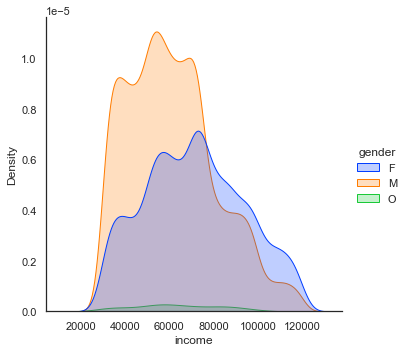

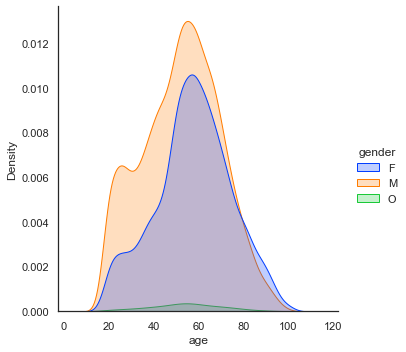

In [1798]:
#How ist the distribution of age and income in the dataset seperated by gender
sns.set_style("white")

sns.displot(data=profile, x='income', hue='gender', kind='kde', fill=True,  palette=sns.color_palette('bright')[:3])
plt.show()


sns.displot(data=profile, x='age', hue='gender', kind='kde', fill=True,  palette=sns.color_palette('bright')[:3])
plt.show()

We can see that the data for income and age follows roughly a normal distribution, with the mean around 70.000 Dollar income and an age of 60.

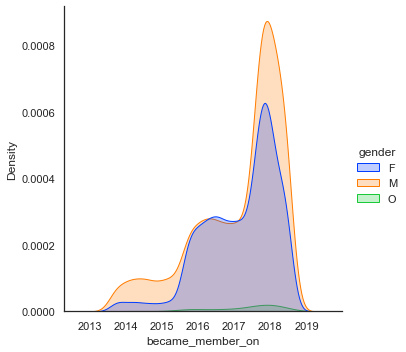

In [1799]:
sns.displot(data=profile, x='became_member_on', hue='gender', kind='kde', fill=True,  palette=sns.color_palette('bright')[:3])

In the became a member year we see that most members joined in the last year before the promotion, or in the year of the promotion. In the following, some advanced plotting with two quantitative and numerical data. In the following a scatter plot of income an age by gender. 

<AxesSubplot:xlabel='income', ylabel='age'>

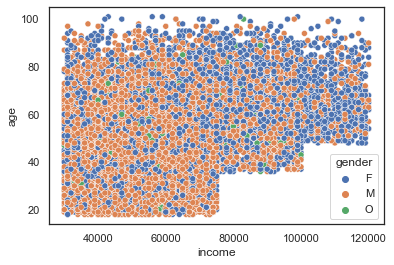

In [1800]:
sns.scatterplot(data=profile, x="income", y="age", hue="gender")

We can see that the data is sumulated data as we have two steps in the income correlated to age. The gender distributions seems, that more female customer have a better income with higher age.

In the following some data exploration with vizualization, but nothing of intrest. Therefore no further explination on the result it given.

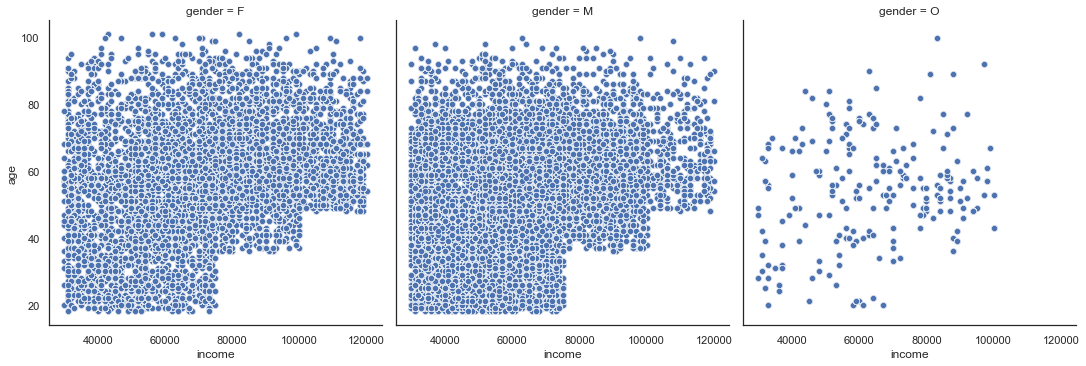

In [1801]:
sns.relplot(data=df, x="income", y="age", col='gender', kind="scatter")

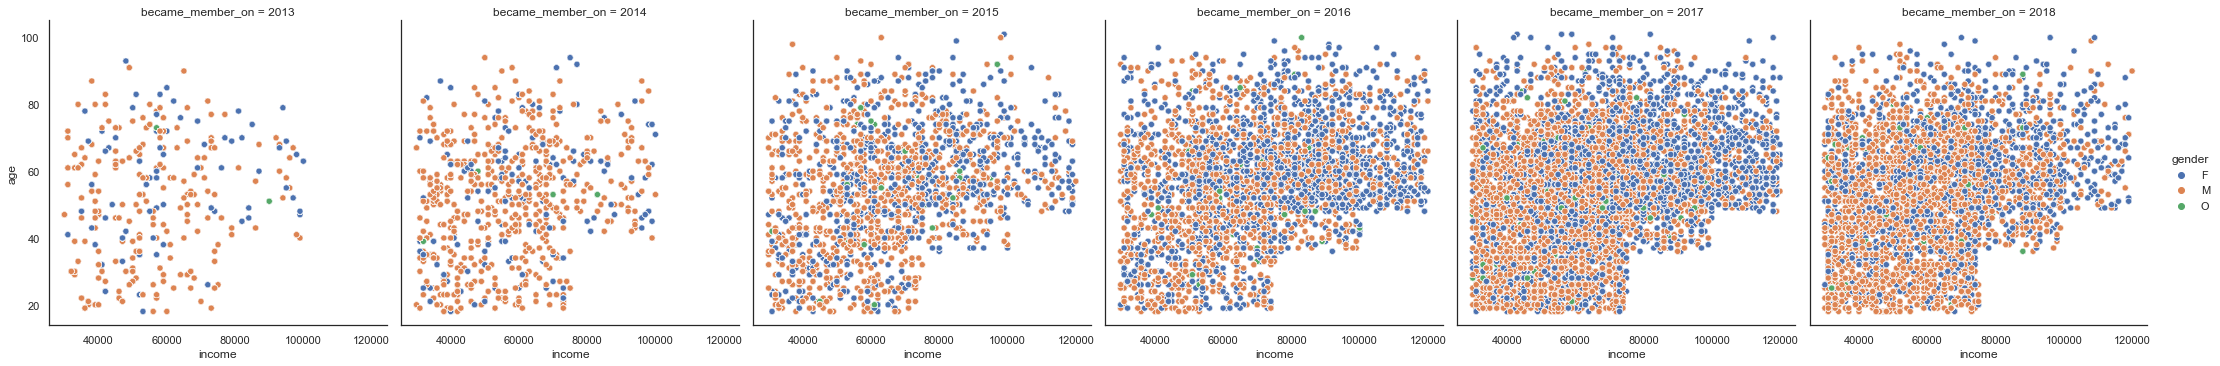

In [1802]:
sns.relplot(data=df, x="income", y="age", hue="gender", col='became_member_on', kind="scatter")

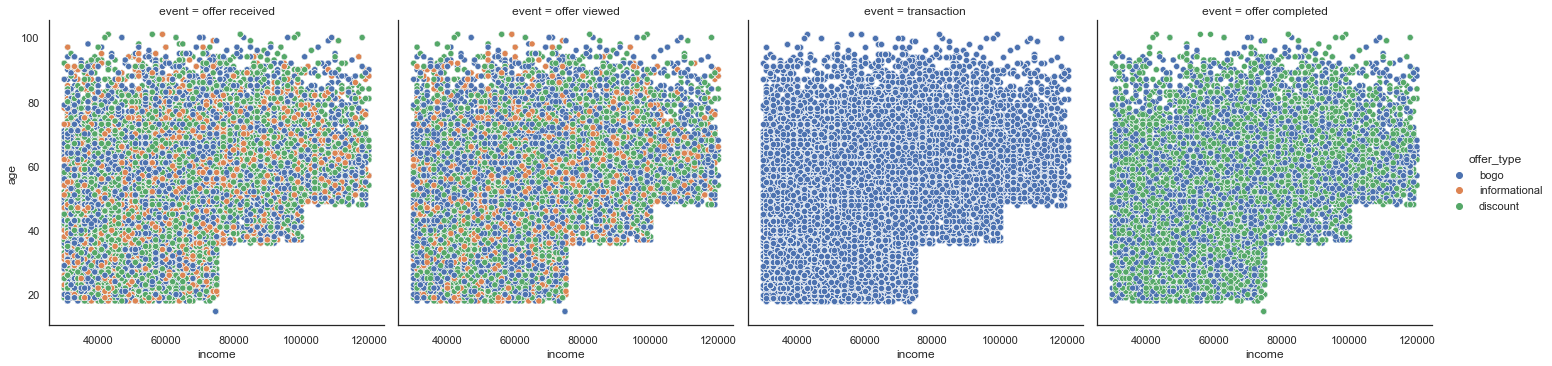

In [1803]:
sns.relplot(data=df, x="income", y="age", hue="offer_type", col='event', kind="scatter")

In [1804]:
#Copy the data set to explore more difficult plots.
df2 = df.copy()
df = df.dropna(subset=['offer_id'])

In the following the data is seperated by the different offer types made and if the customer completed, viewed or receveid an offer.

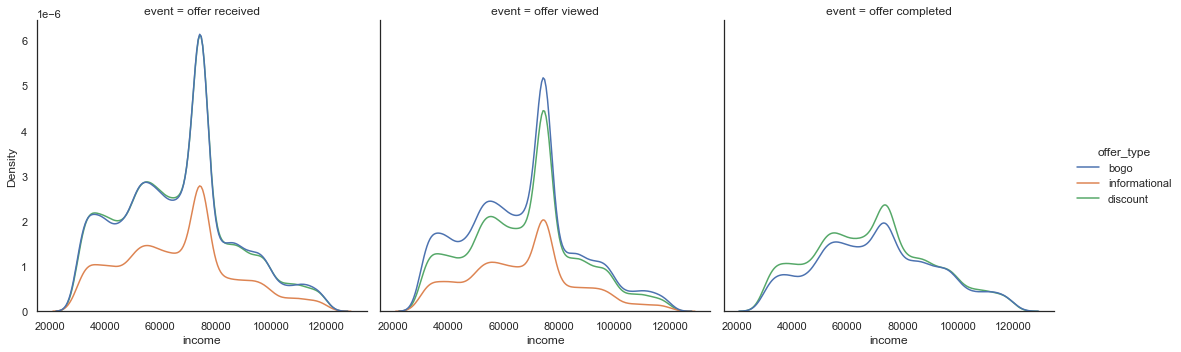

In [1805]:
sns.displot(data=df, x='income', hue='offer_type', col='event', kind='kde')

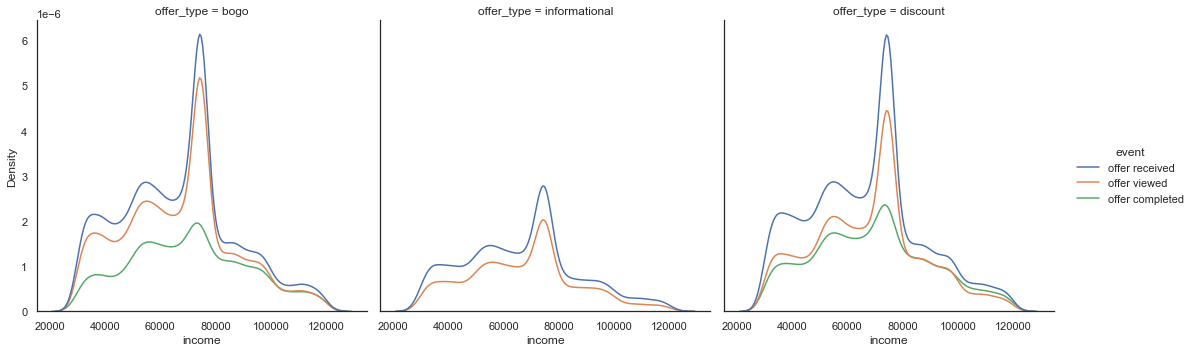

In [1806]:
sns.displot(data=df, x='income', hue='event', col='offer_type', kind='kde');

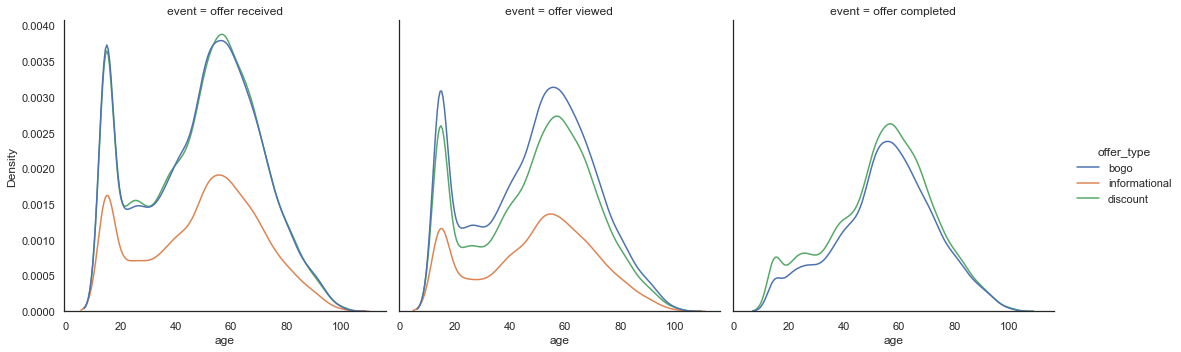

In [1807]:
sns.displot(data=df, x='age', hue='offer_type', col='event', kind='kde')

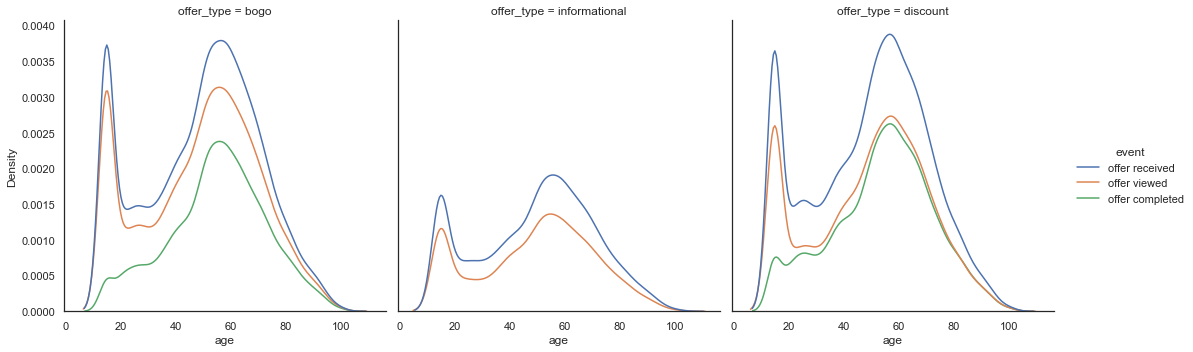

In [1808]:
sns.displot(data=df, x='age', hue='event', col='offer_type', kind='kde');

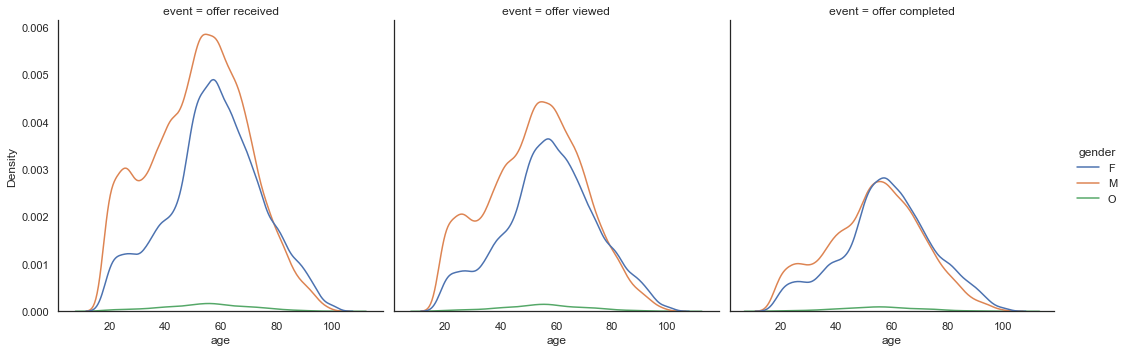

In [1809]:
sns.displot(data=df, x='age', hue='gender', col='event', kind='kde')

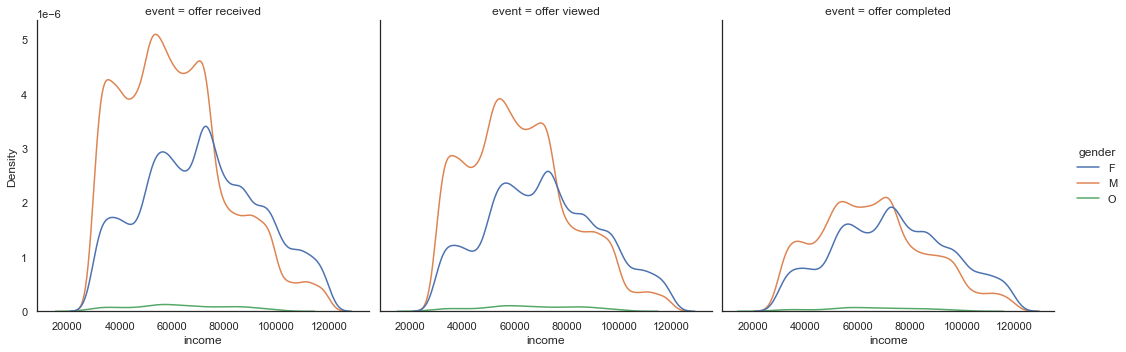

In [1810]:
sns.displot(data=df, x='income', hue='gender', col='event', kind='kde')

We can see that the distribution for offer made and offer viewed follows a similar distribution. With a peak for the income around 100.000 Dollar.  Informational offer being the least, and not in the offer completed as there is no benefit in the information offer.

# 3. Data Preprocessing
For training a model we need to create a label, which we consider a sucess oder non sucess offer. 
* A Sucess would be an offer views and offer completed
* A Non success would be an offer viewd and no offer competed

But there are also customers that receive an offer and buy something nevertheless of the offer. Different data cleaning procceses have already been made, e.g. filling in income and wrong age data with the normal distribution, for more detail see above. In the following the data is being prepared to fit better into a model and to create and label that can mark an transaction as succsefull or not.

## 3.1 Create a Label for successful offer

In [1811]:
#copy the dataset to work on a copy to come back to the original dataset if something goes wrong
prepro = transcript.copy()
port = portfolio.copy()

In [1812]:
#combine the transcript and a part of the portfolio dataset
#to determine which transaction have been because of a succsefull offer
prepro = prepro.sort_values(['customer_id', 'time'])
prepro['offer_succ'] = 0 #variable to determine if a offer was succesfull
prepro['num_off'] = 0 #variable to count how many offers a customer got
prepro.head(10)

,customer_id,event,time,amount,reward,offer_id,offer_succ,num_off
55972,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0
77705,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0
89291,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,NaN,NaN,0,0
113605,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0,0
139992,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,NaN,3f207df678b143eea3cee63160fa8bed,0,0
153401,0009655768c64bdeb2e877511632db8f,offer received,408,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0,0
168412,0009655768c64bdeb2e877511632db8f,transaction,414,8.57,NaN,NaN,0,0
168413,0009655768c64bdeb2e877511632db8f,offer completed,414,NaN,5.0,f19421c1d4aa40978ebb69ca19b0e20d,0,0
187554,0009655768c64bdeb2e877511632db8f,offer viewed,456,NaN,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0,0
204340,0009655768c64bdeb2e877511632db8f,offer received,504,NaN,NaN,fafdcd668e3743c1bb461111dcafc2a4,0,0


In [1813]:
#combine the transcript and a part of the portfolio dataset
#to determine which transaction have been because of a succsefull 
offerport = port[{'offer_id', 'duration', 'offer_type'}]
prepro = prepro.merge(offerport, how='left',on='offer_id')
prepro = prepro.drop(columns={'reward'})

In [1814]:
#check the dataset before further steps
prepro.head(20)

,customer_id,event,time,amount,offer_id,offer_succ,num_off,duration,offer_type
0,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0,72.0,informational
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0,72.0,informational
2,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,NaN,0,0,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,3f207df678b143eea3cee63160fa8bed,0,0,96.0,informational
4,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,3f207df678b143eea3cee63160fa8bed,0,0,96.0,informational
5,0009655768c64bdeb2e877511632db8f,offer received,408,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0,0,120.0,bogo
6,0009655768c64bdeb2e877511632db8f,transaction,414,8.57,NaN,0,0,NaN,NaN
7,0009655768c64bdeb2e877511632db8f,offer completed,414,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0,0,120.0,bogo
8,0009655768c64bdeb2e877511632db8f,offer viewed,456,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0,0,120.0,bogo
9,0009655768c64bdeb2e877511632db8f,offer received,504,NaN,fafdcd668e3743c1bb461111dcafc2a4,0,0,240.0,discount


Here is the deciding step to clean the data to create a label that tells us if a transaction is due to an offer or not. This is pretty complicated, due to the fact that a customer can purchase something without an offer made or without seing the offer made to him. I tried different ways to avoid complicated if loops, but didnt find away arround it. so the following is the chaos to create a successful metric over the time elapsed per customer.

In this dataset before processing, we can see that the event doesn’t follow a pattern which makes the definition of a successful offer difficult, as the offer received for an informational campaign can result in an purchase, but in between there were multiple other offers made, but not viewed. And Bogo or discount was only successful if the if the transaction is completed. See details in the PDF of the repo

In [1815]:
def find_succesfull_offers(dataframe):
    """
    This function returns a dataframe with an added colum "offer_succ" which means if
    the transaction is due to an succsefful offer. the values can range from -1 to 1 (integer)
    
    Input: is a dataframe containing the transaction data
    
    Output: is a dataframe containing the transaction data plus the offer evaluation
    """
    datafr = dataframe.copy()
    viewd = False
    customer_id = datafr.loc[0, 'customer_id']
    customer_offer_counter = 0
    offer_viewd = 0
    #loop through the whole dataframe which is sorted by customer and time
    for idx in range(datafr.shape[0]):
        #check if new customer is reached
        if datafr.loc[idx, 'customer_id']!=customer_id:
            customer_offer_counter = 0
            customer_id = datafr.loc[idx, 'customer_id']
            offer_time = 0
            offer_id = ''
            duration = 0
            viewd = False
            offer_viewd = 0
            
        
        #Check if event is 'offer received'
        if datafr.loc[idx, 'event'] == 'offer received':
            offer_time = datafr.loc[idx, 'time']
            offer_id = datafr.loc[idx, 'offer_id']
            duration = datafr.loc[idx, 'duration']
            customer_offer_counter = customer_offer_counter +1
            datafr.loc[idx, 'num_off'] = customer_offer_counter
            #viewd = False
            
        #Check if event is 'offer viewed'
        if datafr.loc[idx, 'event'] == 'offer viewed' and datafr.loc[idx, 'offer_id'] == offer_id:
            viewd = True
            otype = datafr.loc[idx, 'offer_type']
            offer_viewd = datafr.loc[idx, 'offer_id']
            
        #Check if event is 'transaction'        
        if datafr.loc[idx, 'event'] == 'transaction' and viewd == True:
            if otype == 'informational': #and #duration <= datafr.loc[idx,'time']-offer_time:
                datafr.loc[idx, 'offer_succ'] = 1
                datafr.loc[idx, 'offer_id'] = offer_viewd
                datafr.loc[idx, 'offer_type'] = otype
                datafr.loc[idx, 'num_off'] = customer_offer_counter
                offer_time = 0
                offer_id = ''
                duration = 0
                viewd = False
                offer_viewd = 0
            if otype == 'bogo' or otype == 'discount':
                if datafr.loc[idx+1, 'event'] == 'offer completed' and datafr.loc[idx+1, 'offer_id'] == offer_viewd:
                    datafr.loc[idx, 'offer_succ'] = 1
                    datafr.loc[idx, 'offer_id'] = offer_viewd
                    datafr.loc[idx, 'offer_type'] = otype
                    datafr.loc[idx, 'num_off'] = customer_offer_counter
                    offer_time = 0
                    offer_id = ''
                    duration = 0 
                    viewd = False
                    offer_viewd = 0
                #else:
        elif datafr.loc[idx, 'event'] == 'transaction' and viewd == False:            
            datafr.loc[idx, 'offer_succ'] = 0
            datafr.loc[idx, 'offer_id'] = offer_viewd
            datafr.loc[idx, 'offer_type'] = otype
            datafr.loc[idx, 'num_off'] = customer_offer_counter
            offer_time = 0
            offer_id = ''
            duration = 0 
            viewd = False  
            offer_viewd = 0 

    
    
    return datafr

In [1816]:
#copy the dataset into a seperate dataset for test purposes during development, only a sub-sample has been taken during
#development due to the inefficent way of getting the label
test = prepro[:100000].copy()

In [1817]:
test.head(15)

,customer_id,event,time,amount,offer_id,offer_succ,num_off,duration,offer_type
0,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0,72.0,informational
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0,72.0,informational
2,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,NaN,0,0,NaN,NaN
3,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,3f207df678b143eea3cee63160fa8bed,0,0,96.0,informational
4,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,3f207df678b143eea3cee63160fa8bed,0,0,96.0,informational
5,0009655768c64bdeb2e877511632db8f,offer received,408,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0,0,120.0,bogo
6,0009655768c64bdeb2e877511632db8f,transaction,414,8.57,NaN,0,0,NaN,NaN
7,0009655768c64bdeb2e877511632db8f,offer completed,414,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0,0,120.0,bogo
8,0009655768c64bdeb2e877511632db8f,offer viewed,456,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0,0,120.0,bogo
9,0009655768c64bdeb2e877511632db8f,offer received,504,NaN,fafdcd668e3743c1bb461111dcafc2a4,0,0,240.0,discount


In [1818]:
success_feature = find_succesfull_offers(test)

In [1819]:
success_feature.head(40)

,customer_id,event,time,amount,offer_id,offer_succ,num_off,duration,offer_type
0,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,0,1,72.0,informational
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0,72.0,informational
2,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,5a8bc65990b245e5a138643cd4eb9837,1,1,NaN,informational
3,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,3f207df678b143eea3cee63160fa8bed,0,2,96.0,informational
4,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,3f207df678b143eea3cee63160fa8bed,0,0,96.0,informational
5,0009655768c64bdeb2e877511632db8f,offer received,408,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0,3,120.0,bogo
6,0009655768c64bdeb2e877511632db8f,transaction,414,8.57,3f207df678b143eea3cee63160fa8bed,1,3,NaN,informational
7,0009655768c64bdeb2e877511632db8f,offer completed,414,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0,0,120.0,bogo
8,0009655768c64bdeb2e877511632db8f,offer viewed,456,NaN,f19421c1d4aa40978ebb69ca19b0e20d,0,0,120.0,bogo
9,0009655768c64bdeb2e877511632db8f,offer received,504,NaN,fafdcd668e3743c1bb461111dcafc2a4,0,4,240.0,discount


## 3.2 Concat all the features for the Model together (Feature Engineering)
Now we created a label, the features are combined into one data frame to be put in the model. In further steps, all important data in linked back together and some new features are being calculated. Such as number of offers made to a customer, membership days. All data is changed into integer and numerical to be calculable. Categorical data is changed with one hot encoding.

In [1820]:
def get_features(input_data):
    '''  
    inputs:
    - df: original dataframe for modeling 

    outputs:
    - Returns dataframe containing engineered features, filled missing values and cleaned and transformed variables      
    '''
    #Put all the features together into one dataframe
    data = input_data[input_data['event']== 'transaction']
    data = data.drop(columns= ['duration', 'offer_type'])
    data= pd.merge(data, profile, on='customer_id')
    data = pd.merge(data, portfolio, on='offer_id', how='left')
    data = data.drop(columns= ['event', 'time', 'duration'])

    #one hote encode the offer type
    dummy2 = pd.get_dummies(data['offer_type'])
    data = pd.concat([data, dummy2], axis=1)
    data = data.drop(columns='offer_type')

    #one hot encode gener
    dummy2 = pd.get_dummies(data['gender'])
    data = pd.concat([data, dummy2], axis=1)
    data = data.drop(columns='gender')

    #Create a feature of how many days a customer is a member
    data['member_days'] ='20181231'
    data['member_days'] = pd.to_datetime(data['member_days'], format='%Y%m%d')
    data['mdays'] = (data['member_days'] -data['became_member_on']).dt.days
    data = data.drop(columns= ['member_days', 'became_member_on'])
    columnss = ['customer_id', 'offer_id', 'mdays','num_off', 'amount',
                'age','income', 'reward', 'difficulty','email', 'mobile', 'social', 
                'web', 'discount','informational', 'M', 'O','offer_succ']
    data = data[columnss]
    
    data = data.fillna(0)
    data[['offer_succ','num_off', 'amount', 'age','income', 'reward', 'difficulty',
          'email', 'mobile', 'social', 'web', 'discount','informational', 'M', 'O','mdays']] = \
    data[['offer_succ','num_off', 'amount', 'age','income', 'reward', 'difficulty','email', 
          'mobile', 'social', 'web', 'discount','informational', 'M', 'O','mdays']].astype(int)
    
    offer_id = data['offer_id'].unique()
    offer_dict = pd.Series(offer_id).to_dict()
    offer_dict = dict([(value, key) for key, value in offer_dict.items()]) 
    data['offer_id'] = data['offer_id'].map(offer_dict)
    
    data[['offer_id', 'offer_succ','num_off', 'amount', 'age','income', 'reward', 'difficulty','email', 
      'mobile', 'social', 'web', 'discount','informational', 'M', 'O','mdays']].astype(int)
    
    data = data.drop(columns= ['offer_id'])
    
    return data

In [1821]:
#create the label and have a look at the data
data = get_features(success_feature)
data.head()

,customer_id,mdays,num_off,amount,age,income,reward,difficulty,email,mobile,social,web,discount,informational,M,O,offer_succ
0,0009655768c64bdeb2e877511632db8f,619,1,22,33,72000,0,0,1,1,1,0,0,1,1,0,1
1,0009655768c64bdeb2e877511632db8f,619,3,8,33,72000,0,0,1,1,0,1,0,1,1,0,1
2,0009655768c64bdeb2e877511632db8f,619,4,14,33,72000,0,0,0,0,0,0,0,0,1,0,0
3,0009655768c64bdeb2e877511632db8f,619,4,13,33,72000,0,0,0,0,0,0,0,0,1,0,0
4,0009655768c64bdeb2e877511632db8f,619,5,10,33,72000,0,0,0,0,0,0,0,0,1,0,0


In [1822]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45455 entries, 0 to 45454
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customer_id    45455 non-null  object
 1   mdays          45455 non-null  int32 
 2   num_off        45455 non-null  int32 
 3   amount         45455 non-null  int32 
 4   age            45455 non-null  int32 
 5   income         45455 non-null  int32 
 6   reward         45455 non-null  int32 
 7   difficulty     45455 non-null  int32 
 8   email          45455 non-null  int32 
 9   mobile         45455 non-null  int32 
 10  social         45455 non-null  int32 
 11  web            45455 non-null  int32 
 12  discount       45455 non-null  int32 
 13  informational  45455 non-null  int32 
 14  M              45455 non-null  int32 
 15  O              45455 non-null  int32 
 16  offer_succ     45455 non-null  int32 
dtypes: int32(16), object(1)
memory usage: 3.5+ MB


# 4. Implementation
## 4.1 First Model
The data has been cleand and prepared for the implementation. The goal was to analyse the drivers of an effective offer, with the label variable being. First step therefore is to divide the dataset into features dataset and label dataset. 

In [1836]:
def data_prep(dataframe):
    '''
    inputs:
    - df: prepared dataframe for modeling 
    
    outputs:
    - Returns 2 dataframes - features and labels dataframes
    '''
    # Split the data into features and target label
    labels = dataframe['offer_succ']
    features = dataframe.drop(columns = ['offer_succ', 'customer_id'], inplace=False,axis=1)
    return features, labels

In [1837]:
#Get the data seperated
features, labels = data_prep(data)

Afterwards the data is put into the model pipeline where all the features with high values a scaled to a min max range between 1 and 0. All binomial values are kept.

In [1838]:
def model_pipeline(features,labels):
    '''
    inputs:
    - features and labels  
    
    outputs:
    - Splits features and labels  to train and test sets, performs feature scaling on both datasets.
    - Outputs X_train, X_test, y_train and y_test dataframes
    '''
    #scaler=StandardScaler()
    #features=scaler.fit_transform(features)
    
    scaler = MinMaxScaler() # default=(0, 1)
    numericals = features.columns[0:7]
    features_transform = pd.DataFrame(data = features)
    features_transform[numericals] = scaler.fit_transform(features[numericals])
    
    #split into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features_transform,labels, test_size=0.30, random_state=12)


    return X_train,X_test,y_train, y_test

In [1839]:
#Split the data into train and test sets
X_train,X_test,y_train, y_test = model_pipeline(features,labels)
X_train.head()

,mdays,num_off,amount,age,income,reward,difficulty,email,mobile,social,web,discount,informational,M,O
23734,0.215934,0.000000,0.001970,0.000000,0.496767,0.0,0.00,0,0,0,0,0,0,0,0
11823,0.291209,0.166667,0.006897,0.413793,0.477778,0.0,0.00,0,0,0,0,0,0,1,0
28263,0.458242,0.833333,0.028571,0.425287,0.466667,0.5,0.25,1,1,1,1,0,0,0,0
16217,0.475824,0.500000,0.014778,0.701149,0.911111,0.0,0.00,0,0,0,0,0,0,0,0
25855,0.028571,0.000000,0.003941,0.264368,0.144444,0.0,0.00,0,0,0,0,0,0,0,0


In [1845]:
#check the distribution of the label in the test and train set
print("Results of the split\n------")
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

print("\nLabels distribution\n------")
print('y_train labels distribution')
print(y_train.value_counts())
print('y_test labels distribution')
print(y_test.value_counts())

Results of the split
------
Training set has 31818 samples.
Testing set has 13637 samples.

Labels distribution
------
y_train labels distribution
0    25856
1     5962
Name: offer_succ, dtype: int64
y_test labels distribution
0    11078
1     2559
Name: offer_succ, dtype: int64


The Distribution of the label is a bit uneven, but not to imbalanced that it can not used for training anymore. Since the label is so imbalanced we use the f1 score to get a better grip on model performance to just accuracy. The f1 score takes both false positives and false negatives into account. F1 score gives more weightage to true positive, which is what we are looking for, as we want to see successful offers.

Create train predict function that prints out the scores of the model entered.

In [1841]:
def train_predict(model, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - model: the learning algorithm to be trained and predicted on
       - X_train: features training set
       - y_train: review_scores_rating training set
       - X_test: features testing set
       - y_test: review_scores_rating testing set
    '''
    results = {}
    
    #Fit the learner to the training data and get training time
    start = time() 
    model = model.fit(X_train, y_train)
    end = time() 
    results['train_time'] = end-start
    
    # Get predictions on the test set(X_test)
    start = time() 
    predictions_test = model.predict(X_test)
    predictions_train = model.predict(X_train)
    end = time() 
    
    # Calculate the total prediction time
    results['pred_time'] = end-start
    
    #add training accuracy to results
    results['training_score']=model.score(X_train,y_train)
    
    #add testing accuracy to results
    results['testing_score']=model.score(X_test,y_test)
    
    print('########################################################################')
    print("{} trained on {} samples.".format(model.__class__.__name__, len(y_train)))
    print('- - - - - - - - - - - - - - - - - - - - - - - - - - ')
    print("MSE_train: %.4f" % mean_squared_error(y_train,predictions_train))
    print("MSE_test: %.4f" % mean_squared_error(y_test,predictions_test))
    print("Training accuracy:%.4f" % results['training_score'])
    print("Test accuracy:%.4f" % results['testing_score'])
    print(classification_report(y_test, predictions_test,digits=4))
    print('########################################################################')
    return results

In [1842]:
def run_model(clf1,clf2, clf3, name):
    '''
    inputs:
    - clf1: first classifier model
    - clf2: 2nd classifier model for comparison
    - clf3: 3nd classifier model for comparison
    - name: name of models for comparison
    
    outputs:
    - Dataframe of results from model training and prediction
    '''
    
    # Collect results on the learners
    results = {}
    for clf in [clf1, clf2, clf3]:
        clf_name = clf.__class__.__name__ + '_' +name
        results[clf_name] = {}
        results[clf_name]= train_predict(clf, X_train, y_train, X_test, y_test)
    return pd.DataFrame(results)

Define Function run model, to run three models in a row to compare the results to each other. For the best results we compare three different models DecisionTreeClassifier, GaussianNB and RandomForestClassifier. Since we intend to analyse the feature importance to determine the drivers of an effective offer, a decision tree would provide good interpretability for us to analyse. Gausian NB is taken for a reference.
### Run the model:

In [1843]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

clf1 = clf_A = DecisionTreeClassifier(random_state =42)
clf2 = GaussianNB() #NainveBayes
clf3 = RandomForestClassifier(random_state =42, n_estimators=10) #EnsembleMethods 

#clf1 = DecisionTreeClassifier(criterion='entropy',max_depth=5,random_state=2,min_samples_split=90,min_samples_leaf=50)
#clf3 = RandomForestClassifier(random_state=2,max_depth= 11, max_features= 'auto',min_samples_split= 10,n_estimators=20,min_samples_leaf=20)

results=run_model(clf1, clf2, clf3,'First_try')


########################################################################
DecisionTreeClassifier trained on 31818 samples.
- - - - - - - - - - - - - - - - - - - - - - - - - - 
MSE_train: 0.0000
MSE_test: 0.0000
Training accuracy:1.0000
Test accuracy:1.0000
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     11078
           1     1.0000    1.0000    1.0000      2559

    accuracy                         1.0000     13637
   macro avg     1.0000    1.0000    1.0000     13637
weighted avg     1.0000    1.0000    1.0000     13637

########################################################################
########################################################################
GaussianNB trained on 31818 samples.
- - - - - - - - - - - - - - - - - - - - - - - - - - 
MSE_train: 0.0000
MSE_test: 0.0000
Training accuracy:1.0000
Test accuracy:1.0000
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000  

The Resulst is not usable, but I cannot find the reason why I get a perfect score. It also doesn’t offer an error message. I already tried to see if I have a linear dependence in my dataset to the label, but also couldn’t find it. The reviewer might have more insight to want went wrong.

## 4.2 Refinment
Although i seem to be getting a perfect score. Which is probably due to an error somewhere. Afer checking with Stackoverflow and other rescources I could not find where the error is terminating. I also dont get an error, so I continue. 

As it is an task in the Udacity Rubrics i will refine the model, although consindering the score there is nothing to refine. 

In [1908]:
# take the Random Forrest Classifer to refine it with Grid Search
#  Initialize the classifier
from sklearn.metrics import make_scorer
clf = RandomForestClassifier(random_state =42)

#Create the paramaters
parameters ={'max_features': ['auto', 'sqrt'],
            'max_depth' : [5,10,15,20],
            'n_estimators': [25,30,40,50],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [2, 10,15, 20],
            }

#  Perform grid search on the classifier
grid_obj = GridSearchCV(clf, parameters)

#Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the best parametrs
best_clf = grid_fit.best_params_

print(best_clf)

{'max_depth': 5, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 25}


In [1909]:
clf1 = clf_A = DecisionTreeClassifier(random_state =42)
clf2 = GaussianNB() #NainveBayes
clf3 = RandomForestClassifier(random_state=2,max_depth= 5, max_features= 'auto',min_samples_split= 2,n_estimators=25)

results=run_model(clf1, clf2, clf3,'Refined')

########################################################################
DecisionTreeClassifier trained on 31818 samples.
- - - - - - - - - - - - - - - - - - - - - - - - - - 
MSE_train: 0.0000
MSE_test: 0.0000
Training accuracy:1.0000
Test accuracy:1.0000
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000     11078
           1     1.0000    1.0000    1.0000      2559

    accuracy                         1.0000     13637
   macro avg     1.0000    1.0000    1.0000     13637
weighted avg     1.0000    1.0000    1.0000     13637

########################################################################
########################################################################
GaussianNB trained on 31818 samples.
- - - - - - - - - - - - - - - - - - - - - - - - - - 
MSE_train: 0.0000
MSE_test: 0.0000
Training accuracy:1.0000
Test accuracy:1.0000
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000  

# 5. Results

## 5.1 Question 1: What are the most important features to predict an offer
To answer the question which feautre is most important to predict a successfull offer, we print the features importance.

<AxesSubplot:>

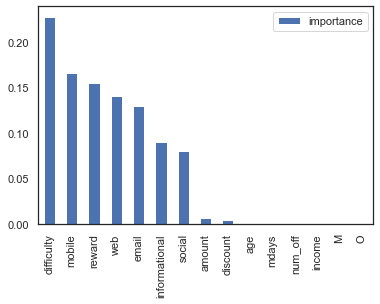

In [1858]:
# Create dataframe with feature importance

feature_importances = pd.DataFrame(clf3.feature_importances_,
                                   index = features.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)

feature_importances.plot.bar()

It seems that the difficulty and the mobile app are the best predicter to a successfull offer. The difficulty was the minimum required spend to complete an offer. This is suprising but that what the prediciton offers. Probably the less to spend to complete an offer the easier it is to be succsessfull.

## 5.2 Question 2:What are the characteristics of an successful offer

In [1859]:
#load the data after pre processing again:
success_feature

,customer_id,event,time,amount,offer_id,offer_succ,num_off,duration,offer_type
0,0009655768c64bdeb2e877511632db8f,offer received,168,NaN,5a8bc65990b245e5a138643cd4eb9837,0,1,72.0,informational
1,0009655768c64bdeb2e877511632db8f,offer viewed,192,NaN,5a8bc65990b245e5a138643cd4eb9837,0,0,72.0,informational
2,0009655768c64bdeb2e877511632db8f,transaction,228,22.16,5a8bc65990b245e5a138643cd4eb9837,1,1,NaN,informational
3,0009655768c64bdeb2e877511632db8f,offer received,336,NaN,3f207df678b143eea3cee63160fa8bed,0,2,96.0,informational
4,0009655768c64bdeb2e877511632db8f,offer viewed,372,NaN,3f207df678b143eea3cee63160fa8bed,0,0,96.0,informational
...,...,...,...,...,...,...,...,...,...
99995,5344678347cc48e48e72d0f25e3e8465,transaction,648,15.97,2298d6c36e964ae4a3e7e9706d1fb8c2,1,4,NaN,discount
99996,5344678347cc48e48e72d0f25e3e8465,offer completed,648,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,0,0,168.0,discount
99997,5344678347cc48e48e72d0f25e3e8465,transaction,654,9.52,0,0,4,NaN,discount
99998,5344678347cc48e48e72d0f25e3e8465,offer completed,654,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,0,240.0,discount


In [1887]:
def get_features2(input_data):
    '''  
    inputs:
    - df: original dataframe for modeling 

    outputs:
    - Returns dataframe containing engineered features, filled missing values and cleaned and transformed variables      
    '''
    #Put all the features together into one dataframe
    data = input_data[input_data['event']== 'transaction']
    data = data.drop(columns= ['duration', 'offer_type'])
    data= pd.merge(data, profile, on='customer_id')
    data = pd.merge(data, portfolio, on='offer_id', how='left')
    data = data.drop(columns= ['event', 'time', 'duration'])

   #Create a feature of how many days a customer is a member
    data['became_member_on'] = data['became_member_on'].dt.year
        
    #data = data.fillna(0)
    #data = data[data['offer_succ']==1]
   
       
    return data

From the below charts we can see that the offers that are completed is distributed across Gender, Age and Income.

Based on Gender, the distribution look very similar and the density for the males that got a successful offer it a bit higher than females. Based on the Age group, the age range of 49-59 is most active while completing the offers followed by 59-69 and 39-49 age range.

Separating by gender, we can see that with male and female the discount and bogo offer are the most successful. The information offer is not as successful. Looking also at the income we can see, females and males behave the same. People with income ranging from 50-80k are the most active ones to complete offers.

Looking further if there is a significant difference between succesful and non succesful offers regarding age and income. We can see from the figure below that, there is virtual no difference ragarding age and income distribution.

Looking lastly at the difficulty of an offer and dividing it by the offer type, we can see that with the discount offer the minimum amount of 10 Dollar is quit successful, which means when there is a discount people tent to buy more expensive drinks. The informational doesn’t offer a difficulty because there is no money to spend on it.

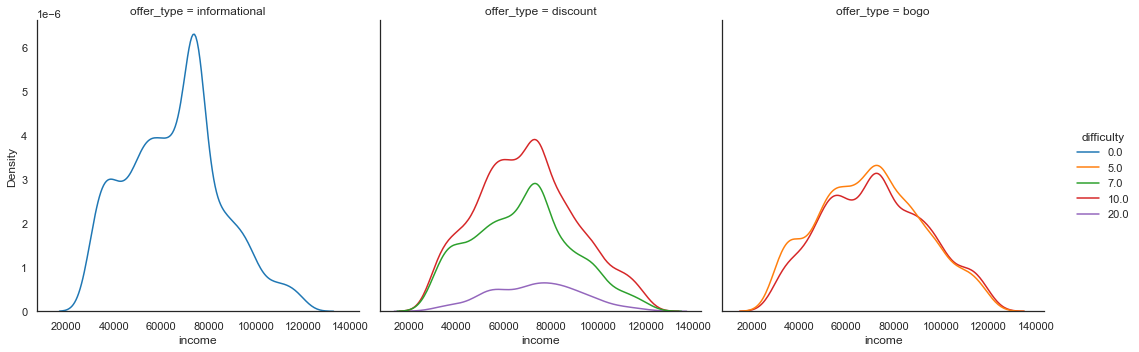

In [1907]:
sns.displot(data=data2[data2['offer_succ']==1], x='income', hue='difficulty', col='offer_type', kind='kde', palette=sns.color_palette("tab10")[:5])

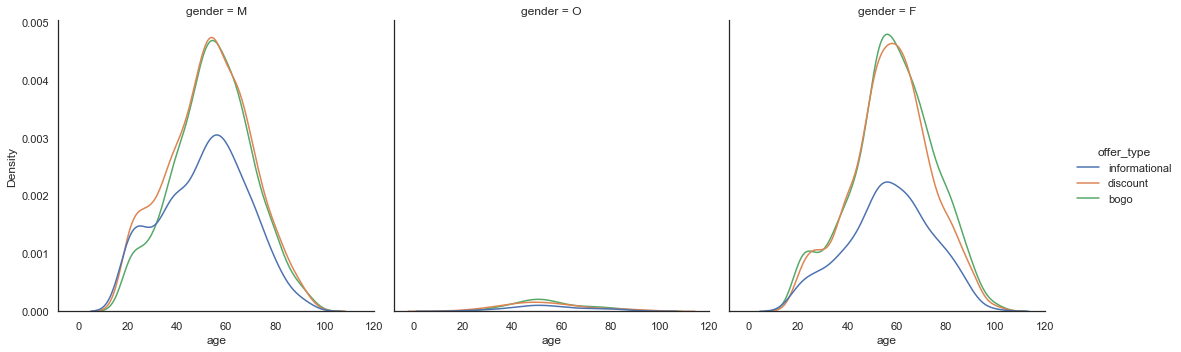

In [1900]:
sns.displot(data=data2[data2['offer_succ']==1], x='age', hue='offer_type', col='gender', kind='kde')

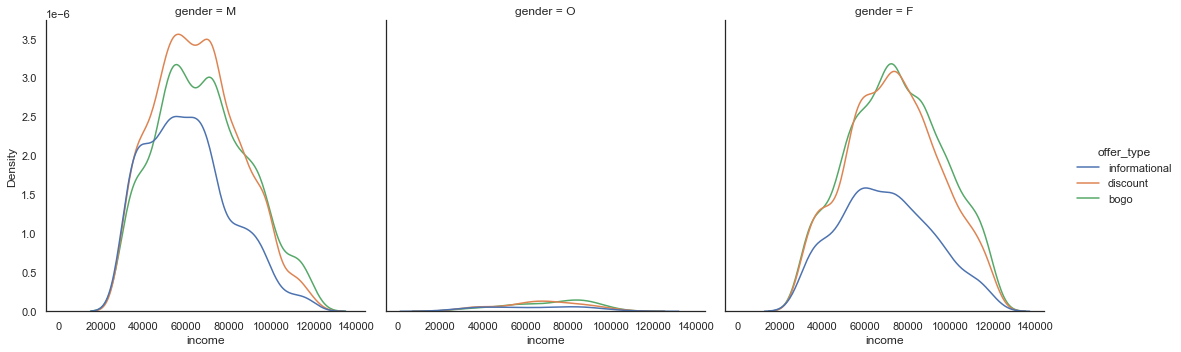

In [1901]:
sns.displot(data=data2[data2['offer_succ']==1], x='income', hue='offer_type', col='gender', kind='kde')

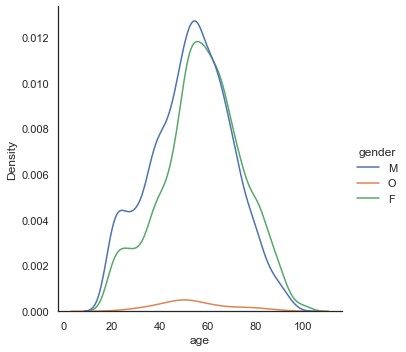

In [1884]:
sns.displot(data=data2[data2['offer_succ']==1], x='age', hue='gender', kind='kde')

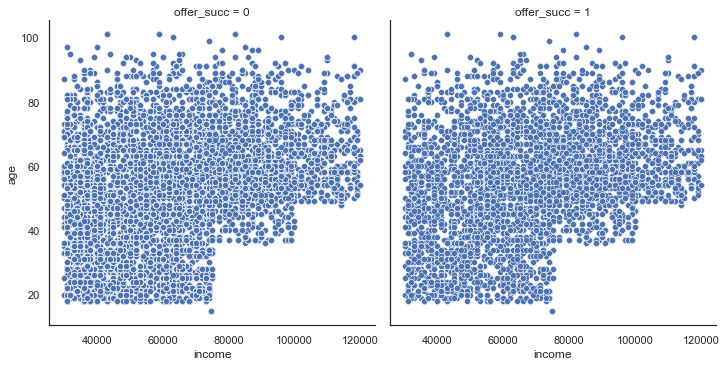

In [1891]:
sns.relplot(data=data2, x="income", y="age", col='offer_succ', kind="scatter")

# 6 Reflection
Reflection
To solve the capstone project, the data was loaded, explored, visualized, preprocessed and put into three different models which were then refined with grid search. Started with three different data files, all were combined to get a label for a successful transaction based on an offer. The question of the most important feature in predicting the success of an offer where made with three different supervised learning models. Other questions were answered with visualizing the processed data. 

Results showed that, the difficulty was the most important feature. In the second question we looked at what were the features of a successful offer and we found that the distribution is normal, where middle income and middle age where the most susccefull offers- Furthermore we found that an offer with a discount of 10 Dollar worked very well.


Challenging in this capstone problem was on one hand getting a understanding of the problem within the transcript data. Meaning that defining what an actual succesfull offer is, wasn’t easy. Even harder was to find a solution within pandas capabilities and find a vectorized solution. I couldn’t find a way to vetorzie the problem, there for I created a function that with a lot of if statement which where not ideal and slow in the calculation. Creating different models with scikit learn was medium difficult due to a lot of online available data and the lessons with its attached notebooks.

Improvement
-	Finding a vetorized filtering of the transcript data set, to get a faster label column
-	Optimizing the machine learning models and finding the error in the data that causes a perfect score
-	Finding different question to ask and solve within the dataset
